In [4]:
import pandas as pd
import numpy as np

# Часть 5. Объединение таблиц

Достаточно часто на практике случаются ситуации, когда данные приходят из разных источников и их нужно свести в один. Иногда такое сведение подразумевает горизонтальное соединение датасетов, а порой - горизонтальное по общим ключам. Именно с рассмотрения этих операций мы и начнём:

## Использование pd.concat

In [5]:
df_1 = pd.DataFrame(
    np.random.randint(1, 11, (2, 3)),
    columns=["a", "b", "c"]
)

df_1

,a,b,c
0,6,10,10
1,7,1,1


In [6]:
df_2 = pd.DataFrame(
    np.random.randint(1, 11, (2, 3)),
    columns=["a", "b", "c"]
)

df_2

,a,b,c
0,10,4,7
1,8,9,7


In [7]:
# горизонтальное объединение
merged = pd.concat([df_1, df_2])
merged

,a,b,c
0,6,10,10
1,7,1,1
0,10,4,7
1,8,9,7


На первый взгляд кажется, что операция прошла успешно. Но обратите внимание на индекс:

In [8]:
merged.index

Index([0, 1, 0, 1], dtype='int64')

In [9]:
merged.loc[0]

,a,b,c
0,6,10,10
0,10,4,7


Pandas сделал ровно то, что от него просили: горизонтально соединил два датасета. При этом никаких указаний про обработку индексов не было, поэтому и здесь никакой дополнительной работы не было сделано. На практике бывают разные случаи: порой такое состояниие действительно предполагается, а порой - нет. Давайте посмотрим, как обезопасить себя, если нужна уникальность в индексе:

In [10]:
# первый способ: verify_integrity
try:
    pd.concat([df_1, df_2], verify_integrity=True)
except Exception as e:
    print("ERROR:\n", e)

ERROR:
 Indexes have overlapping values: Index([0, 1], dtype='int64')


С помощью данного аргумента мы можем явно указать Pandas'у необходимость проверить уникальность индекса. В случае, если это условие не выполняется, то система выдаст ошибку:

In [11]:
# второй способ: ignore_index
pd.concat([df_1, df_2], ignore_index=True)

,a,b,c
0,6,10,10
1,7,1,1
2,10,4,7
3,8,9,7


Использование аргумента `ignore_index` позволяет не обращать внимания на существующие индексы и заново присвоить его получившемуся датасету:

In [12]:
# третий способ: keys
pd.concat([df_1, df_2], keys=["first", "second"])

a   b   c
first  0   6  10  10
       1   7   1   1
second 0  10   4   7
       1   8   9   7

Обратите внимание, что все перечисленные замечания имеют место и при вертикальном объединении (при использовании `axis=1`).

## Использование pd.merge

Функция `pd.merge` в своей работе напоминает join'ы в языке SQL. Поработаем с привычными для нас датафреймами:

In [13]:
num_active_versions = pd.DataFrame(
    [
        {"platform": "website", "num_active_versions": 14},
        {"platform": "ios", "num_active_versions": 4},
        {"platform": "android", "num_active_versions": 8}
    ]
)

num_active_versions

,platform,num_active_versions
0,website,14
1,ios,4
2,android,8


In [14]:
complexity = pd.DataFrame(
    [
        {"platform": "website", "complexity": 1.0},
        {"platform": "ios", "complexity": 1.4},
        {"platform": "android", "complexity": 0.9},
        {"platform": "windows phone", "complexity": 2.1}
    ]
)

complexity

,platform,complexity
0,website,1.0
1,ios,1.4
2,android,0.9
3,windows phone,2.1


Попробуем применить функцию `pd.merge` к нашим датафреймам и посмотрим на результат:

In [15]:
pd.merge(num_active_versions, complexity)

,platform,num_active_versions,complexity
0,website,14,1.0
1,ios,4,1.4
2,android,8,0.9


Обратите внимание, что в результате получился датафрейм с тремя строчками (хотя в последнем из них было 4 строчки). По умолчанию `pd.merge` ищет столбец, присутствующий в обоих датафреймах и производит т.н. inner join (оставляет только те ключи столбца, которые есть в каждом из объединяемых датафреймов)

Чтобы сохранить все требуемые строки,  нужно поменять тип объединения:

In [16]:
pd.merge(num_active_versions, complexity, how="right")

,platform,num_active_versions,complexity
0,website,14.0,1.0
1,ios,4.0,1.4
2,android,8.0,0.9
3,windows phone,NaN,2.1


Теперь у нас есть все требуемые строчки, однако число активных версий для платформы windows phone содержит в себе пустое значение, что соответствует заявленному методу объединения.

Посмотрим, какие ещё объединения возможны. Для этого создадим ещё датафрейм.

In [17]:
languages = pd.DataFrame(
    [
        {"platform": "website", "language": "go"},
        {"platform": "website", "language": "js"},
        {"platform": "ios", "language": "swift"},
        {"platform": "android", "language": "kotlin"},
        {"platform": "android", "language": "java"},
        {"platform": "windows phone", "language": "c#"}
    ]
)

languages

,platform,language
0,website,go
1,website,js
2,ios,swift
3,android,kotlin
4,android,java
5,windows phone,c#


Обратите внимание, что в случае наличия связей один-ко-многим объединение тоже происходит верным образом:

In [18]:
pd.merge(complexity, languages)

,platform,complexity,language
0,website,1.0,go
1,website,1.0,js
2,ios,1.4,swift
3,android,0.9,kotlin
4,android,0.9,java
5,windows phone,2.1,c#


Добавим ещё датафрейм, чтобы посмотреть, что произойдёт в случае связей многим-ко-многим:

In [19]:
programmers = pd.DataFrame(
    [
        {"platform": "website", "name": "Oleg"},
        {"platform": "website", "name": "Nikita"},
        {"platform": "website", "name": "Nadya"},
        {"platform": "android", "name": "Roman"},
        {"platform": "android", "name": "Alex"}
    ]
)

programmers

,platform,name
0,website,Oleg
1,website,Nikita
2,website,Nadya
3,android,Roman
4,android,Alex


In [20]:
pd.merge(languages, programmers)

,platform,language,name
0,website,go,Oleg
1,website,go,Nikita
2,website,go,Nadya
3,website,js,Oleg
4,website,js,Nikita
5,website,js,Nadya
6,android,kotlin,Roman
7,android,kotlin,Alex
8,android,java,Roman
9,android,java,Alex


Как видим, всё прошло успешно (:

# Часть 2. Агрегации

В этом разделе мы будем использовать датасет с информацией о планетах, который доступен в датасете `planets` библиотеки `seaborn` (предварительно сохранённый на локальное устройство)

In [22]:
planets = pd.read_csv("planets.csv")
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


Посмотрим, с какими характеристиками мы можем работать

In [23]:
# пропущенные значения (по столбцам)
planets.isnull().sum()

method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64

In [24]:
# средние значения
planets[["mass", "orbital_period", "distance"]].mean()

mass                 2.638161
orbital_period    2002.917596
distance           264.069282
dtype: float64

In [25]:
# минимальные значения
planets[["mass", "orbital_period", "distance"]].min()

mass              0.003600
orbital_period    0.090706
distance          1.350000
dtype: float64

In [26]:
# максимальные значения
planets[["mass", "orbital_period", "distance"]].max()

mass                  25.0
orbital_period    730000.0
distance            8500.0
dtype: float64

In [27]:
# сводная характеристика
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


Полученные агрегации дают представление о том, какие значения хранятся в датафрейме, однако они существенно нарушают его логическую связность, схлопывая измерения присущие разным методам. Чтобы посмотреть средние характеристики в разрезах различных групп нам понадобятся чуть более сложные инструменты, а именно группировки:

Общий принцип группировки базируется на трёх процедурах:
- split - разбивает данные по группам на основе выбранного ключа
- apply - применяет выбранную агрегацию к каждой из групп
- combine - соединяет данные обратно вместе

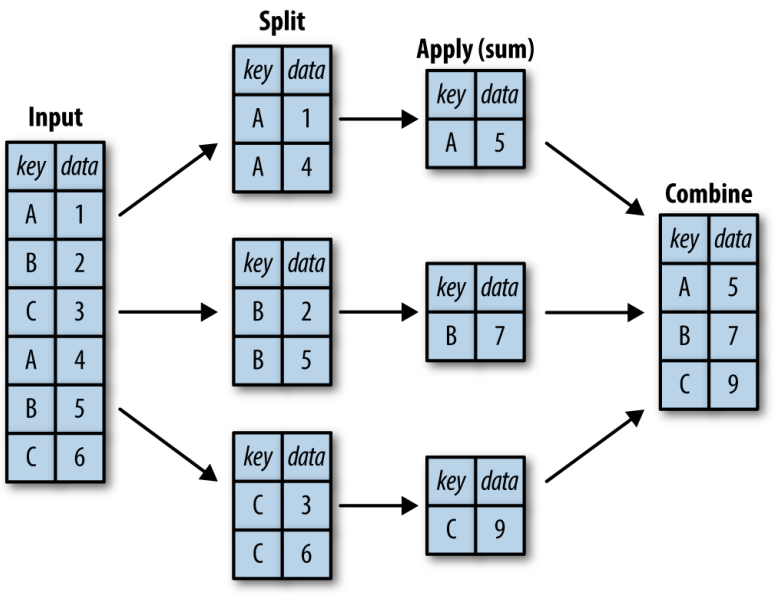

Посмотрим, как выглядят те же агрегации в разрезе наших данных про планеты

In [28]:
# средние данные по орбитальному периоду в разрезах методов измерений
planets.groupby("method")["orbital_period"].mean()

method
Astrometry                          631.180000
Eclipse Timing Variations          4751.644444
Imaging                          118247.737500
Microlensing                       3153.571429
Orbital Brightness Modulation         0.709307
Pulsar Timing                      7343.021201
Pulsation Timing Variations        1170.000000
Radial Velocity                     823.354680
Transit                              21.102073
Transit Timing Variations            79.783500
Name: orbital_period, dtype: float64

In [29]:
# максимальные данные по орбитальному периоду в разрезах методов измерений
planets.groupby("method")["orbital_period"].max()

method
Astrometry                         1016.000000
Eclipse Timing Variations         10220.000000
Imaging                          730000.000000
Microlensing                       5100.000000
Orbital Brightness Modulation         1.544929
Pulsar Timing                     36525.000000
Pulsation Timing Variations        1170.000000
Radial Velocity                   17337.500000
Transit                             331.600590
Transit Timing Variations           160.000000
Name: orbital_period, dtype: float64

# Часть 3. Сводные таблицы

И последний датасет, с которым мы сегодня поработаем - знаменитый Титаник (а точнее информация о пассажирах, которых находились на нём в момент катастрофы).

In [26]:
titanic = pd.read_csv("titanic.csv")

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Сводные таблицы - очень мощный инструмент, знакомый многим со времён работы в системе Microsoft Excel. По сути она обрабатывает табличную информацию, проводя вычисления и представляя результаты в удобной форме. Давайте посмотрим на примере, как это выглядит

In [27]:
# выведем информацию о том, выжил ли пассажир в зависимости от его пола и класса каюты
titanic.pivot_table("survived", index="sex", columns="class")

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Давайте добавим в наш датасет информацию о возрасте в виде принадлежности одному из интервалов (до совершеннолетия и после) и построим многоуровневую сводную таблицу с использованием этих данных

In [28]:
age = pd.cut(titanic["age"], [0, 18, 80])
titanic.pivot_table("survived", index=["sex", age], columns="class")

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

Используя такую информацию, мы можем делать выводы уже в нескольких разрезах одновременно. Что позволяет уже на этапе такого относительно простого анализа порой делать важные выводы

Нужно понимать, что на этом функционал сводных таблиц не заканчивается. В документации есть очень много интересных моментов. Например, можно менять дефолтную функцию агрегации

In [29]:
titanic.pivot_table(
    index=["sex", age], 
    columns="class", 
    aggfunc={"survived": "sum"} # поменяем дефолтную функцию агрегации mean на sum
)

survived             
class              First Second Third
sex    age                           
female (0, 18]        10     14    22
       (18, 80]       72     54    25
male   (0, 18]         4      9    11
       (18, 80]       36      6    27

In [30]:
titanic.pivot_table(
    "survived",
    index="sex", 
    columns="class", 
    margins=True # добавим общую агрегацию по всем трём классам
)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


# Заключение

На этом краткое введение в NumPy и Pandas заканчивается. Нужно понимать, что изложенное ранее - это только азы работы с этими двумя библиотеками. Для дальнейшего изучения можно прибегнуть либо к профильной литературе, либо изучать документацию, в которой исчерпывающе рассказывается о всех возможностях